In [1]:
import numpy as np
from matplotlib import pyplot as plt
import json, math

In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap
from inspect import signature

In [3]:
# read histogram from json file
with open('hist.json') as f:
    ys, vs = json.load(f) # weights and variances (σ²)

step = (160-105)/len(ys)
xs = jnp.linspace(105+step/2 - 125, 160-step/2 - 125, len(ys))

# get rid of bins with non-positive weight
bad = np.nonzero(np.asarray(ys) <= 0)[0]

if len(bad) > 0:
    print("Skipped bins:")
    for i in bad:
        print(i,xs[i],ys[i])
    xs = np.delete(xs,bad)
    ys = np.delete(ys,bad)
    vs = np.delete(vs,bad)

us = np.sqrt(vs)

# logarithmic scale
us = jnp.array(us/ys)
vs = us**2
ys = jnp.log(ys)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Skipped bins:
195 28.874996 -2.3451795598816716e-06


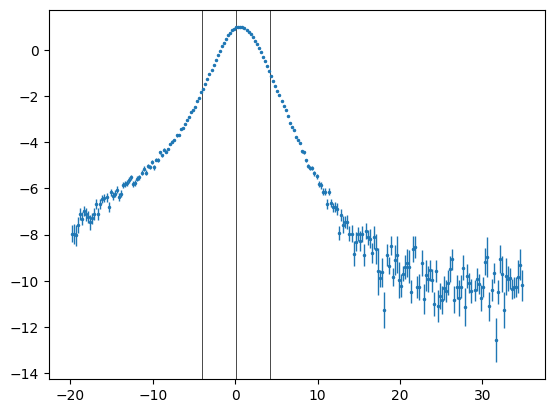

In [4]:
# Identify signal region
core = np.searchsorted(xs,[-4,0,4],side='right')
# Make sure there are at least 3 bins
if core[1] == core[0]:
    core[1] -= 1
if core[2] == core[0]:
    core[2] += 1

plt.errorbar(xs,ys,yerr=us,linestyle='',marker='.',linewidth=1,markersize=3)
plt.axvline(xs[core[0]]-step/2, linewidth = 0.5, color = 'k')
plt.axvline(xs[core[1]], linewidth = 0.5, color = 'k')
plt.axvline(xs[core[2]]+step/2, linewidth = 0.5, color = 'k')
None

In [5]:
# linear least squares fit for second degree polynomial
def fit_core(a,b):
    if b < a:
        a,b = b,a
    b += 1 # [a,b]

    A = np.asarray([ [
        1.,
        x,
        x*x
    ] for x in xs[a:b] ])

    At = np.transpose(A)

    Vi = np.linalg.inv(np.diag(vs[a:b])) # V^-1

    AtVi = np.dot(At,Vi)

    B = np.dot(np.linalg.inv(np.dot(AtVi,A)),AtVi)

    c = np.dot(B,ys[a:b]) # optimized parameters

    return (
        c,
        np.sum( (ys[a:b]-np.dot(A,c))**2 / vs[a:b] )/(b-a) # χ²/N
    )

[ 0.93526462  0.19008018 -0.17580946]
χ²/N = 6.914240837097168


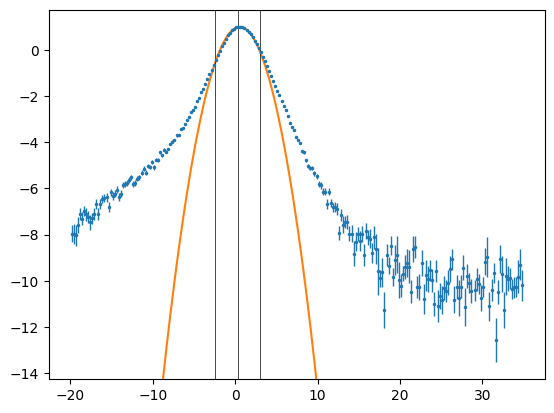

In [6]:
i_core = [70,81,91]

c, χ2 = fit_core(i_core[0],i_core[2])

plt.errorbar(
    xs,ys,yerr=us,
    linestyle='',marker='.',linewidth=1,markersize=3
)
ymin, ymax = plt.ylim()
plt.plot(
    xs,c[0]+xs*c[1]+xs*xs*c[2],
    linestyle='-',marker='',linewidth=1.5
)
plt.ylim(ymin, ymax)
plt.axvline(xs[i_core[1]], linewidth=0.5, color='k')
plt.axvline(xs[i_core[0]]-step/2, linewidth=0.5, color='k')
plt.axvline(xs[i_core[2]]+step/2, linewidth=0.5, color='k')
print(c)
print(f'χ²/N = {χ2}')

$ c_0 + c_1x + c_2x^2
  = \log\left( Ae^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2} \right)
  = \log A -\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2
  = \log A -\frac{1}{2\sigma^2}\left( \mu^2 - 2\mu x + x^2 \right)
$

$c_0 = \log A -\frac{\mu^2}{2\sigma^2}$

$c_1 = \frac{\mu}{\sigma^2}$

$c_2 = -\frac{1}{2\sigma^2}$

$\sigma^2 = -\frac{1}{2c_2}$

$\mu = \sigma^2c_1 = -\frac{c_1}{2c_2}$

$C = \log A = c_0 + \mu c_1 = c_0 - \frac{c_1^2}{2c_2}$

$ x_\mathrm{L} = \mu - \sigma\alpha_\mathrm{L}
  \quad\Rightarrow\quad
  \alpha_\mathrm{L} = \frac{\mu - x_\mathrm{L}}{\sigma}
$

$ x_\mathrm{R} = \mu + \sigma\alpha_\mathrm{R}
  \quad\Rightarrow\quad
  \alpha_\mathrm{R} = \frac{\mu + x_\mathrm{R}}{\sigma}
$

In [7]:
σ2_core = -1/(2*c[2])
σ_core = σ2_core**0.5
μ_core = σ2_core*c[1]
C_core = c[0] + μ_core*c[1]

αL_core = (μ_core - (xs[i_core[0]]-step/2))/σ_core
αR_core = (μ_core + (xs[i_core[2]]+step/2))/σ_core

print(f'C = {C_core}')
print(f'μ = {μ_core}')
print(f'σ = {σ_core}')
print(f'αL = {αL_core}')
print(f'αR = {αR_core}')

C = 1.0380192582582533
μ = 0.540585738750726
σ = 1.6864127519664267
αL = 1.8029909506425232
αR = 2.099476293010147


In [8]:
def dscb(x,C,μ,σ,αL,nL,αH,nH):
    return jnp.piecewise(
        x,
        [
            x < μ-σ*αL,
            x > μ+σ*αH
        ],
        [
            lambda x,C,μ,σ,αL,nL,αH,nH:
                ( C - 0.5*αL**2 ) - jnp.log(1 - ((x-μ)/σ+αL)*αL/nL)*nL,
            lambda x,C,μ,σ,αL,nL,αH,nH:
                ( C - 0.5*αH**2 ) - jnp.log(1 + ((x-μ)/σ-αH)*αH/nH)*nH,
            lambda x,C,μ,σ,αL,nL,αH,nH:
                C - 0.5*((x-μ)/σ)**2
        ],
        C,μ,σ,αL,nL,αH,nH
    )

dscb_args = list(signature(dscb).parameters)[1:]
N = len(dscb_args)
print(N,dscb_args)

dscb_jit = jit(dscb)

def dscb_plot(C,μ,σ,αL,nL,αH,nH):
    for name in dscb_args:
        print(f'{name} = {locals()[name]}')
    plt.errorbar(xs,ys,yerr=us,linestyle='',marker='.',linewidth=1,markersize=3)
    ymin, ymax = plt.ylim()
    plt.plot(xs,
        C - 0.5*((xs-μ)/σ)**2,
        linestyle='--',marker='',linewidth=1,color='r')
    plt.plot(xs,dscb_jit(
        xs,
        C,μ,σ,αL,nL,αH,nH
    ),linestyle='-',marker='',linewidth=1.5)
    plt.ylim(ymin, ymax)
    plt.axvline(μ-σ*αL, linewidth = 0.5, color = 'k')
    plt.axvline(μ+σ*αL, linewidth = 0.5, color = 'k')

7 ['C', 'μ', 'σ', 'αL', 'nL', 'αH', 'nH']


C = 1.0380192582582533
μ = 0.540585738750726
σ = 1.6864127519664267
αL = 1.8029909506425232
nL = 2.0
αH = 2.099476293010147
nH = 2.0


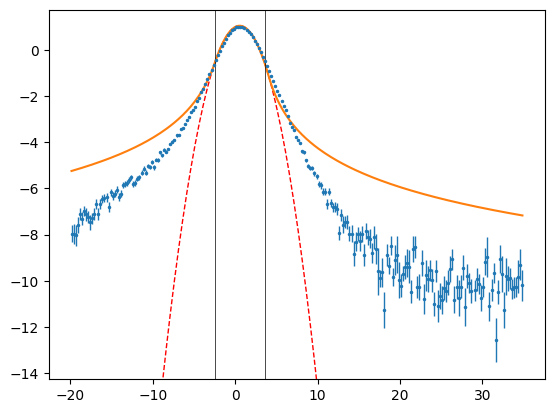

In [9]:
cs0 = [C_core,μ_core,σ_core,αL_core,2.,αR_core,2.]
dscb_plot(*cs0)

In [10]:
def dscb_loss(xs,C,μ,σ,αL,nL,αH,nH,ys,us):
    return jnp.sum(((dscb(xs,C,μ,σ,αL,nL,αH,nH) - ys)/us)**2)

dscb_loss_jit = jit(dscb_loss)

In [11]:
dscb_loss_grad = jit(grad(dscb_loss, argnums=jnp.arange(N)+1))

In [12]:
learning_rate = [
    1e-7, # C
    5e-7, # μ
    1e-7, # σ
    1e-6, # αL
    1e-3, # nL
    1e-6, # αH
    1e-3  # nH
]

def gradient_descent(ii,cs,learning_rate=learning_rate):
    cs = [ *cs ]
    epoch = 0
    while True:
        print(f'\n***** Iteration {epoch} *****')
        cs_prev = [ *cs ]
        d = dscb_loss_grad(xs,*cs,ys,us)
        for i in ii:
            cs[i] -= max(min( learning_rate[i] * d[i], 0.1 ), -0.1)
            print(f'{dscb_args[i]} = {cs_prev[i]} → {cs[i]}, ∂f/∂{dscb_args[i]} = {d[i]}')
        f = dscb_loss_jit(xs,*cs,ys,us)
        print(f'f = {f:g}')
        if math.isnan(f):
            break
        df = sum( d[i]**2 for i in ii )**0.5
        print(f'df = {df:g}')
        if sum( abs(d[i]) < 0.1 for i in ii )==len(ii) or epoch >= 1000:
            break
        epoch += 1
    return cs

In [13]:
cs1 = gradient_descent([4],cs0,learning_rate=[0,0,0,0,1e-4,0,0])


***** Iteration 0 *****
nL = 2.0 → 2.1, ∂f/∂nL = -11533.1953125
f = 20787.2
df = 11533.2

***** Iteration 1 *****
nL = 2.1 → 2.2, ∂f/∂nL = -10176.5009765625
f = 19831.4
df = 10176.5

***** Iteration 2 *****
nL = 2.2 → 2.3000000000000003, ∂f/∂nL = -8961.1494140625
f = 18990.8
df = 8961.15

***** Iteration 3 *****
nL = 2.3000000000000003 → 2.4000000000000004, ∂f/∂nL = -7869.1826171875
f = 18254
df = 7869.18

***** Iteration 4 *****
nL = 2.4000000000000004 → 2.5000000000000004, ∂f/∂nL = -6885.4189453125
f = 17610.6
df = 6885.42

***** Iteration 5 *****
nL = 2.5000000000000004 → 2.6000000000000005, ∂f/∂nL = -5996.95751953125
f = 17051.8
df = 5996.96

***** Iteration 6 *****
nL = 2.6000000000000005 → 2.7000000000000006, ∂f/∂nL = -5192.759765625
f = 16569.5
df = 5192.76

***** Iteration 7 *****
nL = 2.7000000000000006 → 2.8000000000000007, ∂f/∂nL = -4463.33544921875
f = 16156.9
df = 4463.34

***** Iteration 8 *****
nL = 2.8000000000000007 → 2.900000000000001, ∂f/∂nL = -3800.49169921875
f = 

C = 1.0380192582582533
μ = 0.540585738750726
σ = 1.6864127519664267
αL = 1.8029909506425232
nL = 3.6670567989349365
αH = 2.099476293010147
nH = 2.0


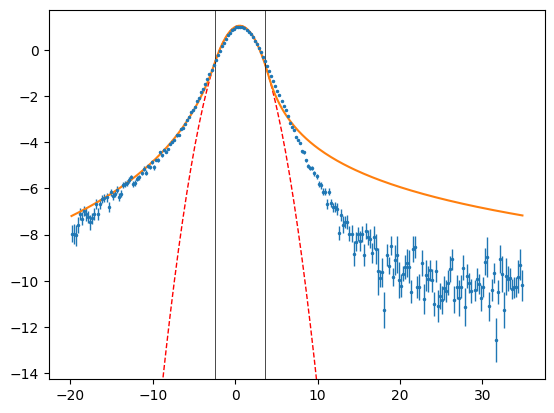

In [14]:
dscb_plot(*cs1)

In [15]:
cs2 = gradient_descent([6],cs1)


***** Iteration 0 *****
nH = 2.0 → 2.1, ∂f/∂nH = -5254.25390625
f = 14223.4
df = 5254.25

***** Iteration 1 *****
nH = 2.1 → 2.2, ∂f/∂nH = -4648.625
f = 13786.3
df = 4648.62

***** Iteration 2 *****
nH = 2.2 → 2.3000000000000003, ∂f/∂nH = -4103.08056640625
f = 13401
df = 4103.08

***** Iteration 3 *****
nH = 2.3000000000000003 → 2.4000000000000004, ∂f/∂nH = -3609.9951171875
f = 13062.8
df = 3610

***** Iteration 4 *****
nH = 2.4000000000000004 → 2.5000000000000004, ∂f/∂nH = -3162.945068359375
f = 12767.1
df = 3162.95

***** Iteration 5 *****
nH = 2.5000000000000004 → 2.6000000000000005, ∂f/∂nH = -2756.475341796875
f = 12510.3
df = 2756.48

***** Iteration 6 *****
nH = 2.6000000000000005 → 2.7000000000000006, ∂f/∂nH = -2385.93115234375
f = 12288.8
df = 2385.93

***** Iteration 7 *****
nH = 2.7000000000000006 → 2.8000000000000007, ∂f/∂nH = -2047.322998046875
f = 12099.8
df = 2047.32

***** Iteration 8 *****
nH = 2.8000000000000007 → 2.900000000000001, ∂f/∂nH = -1737.199951171875
f = 119

C = 1.0380192582582533
μ = 0.540585738750726
σ = 1.6864127519664267
αL = 1.8029909506425232
nL = 3.6670567989349365
αH = 2.099476293010147
nH = 3.594661235809326


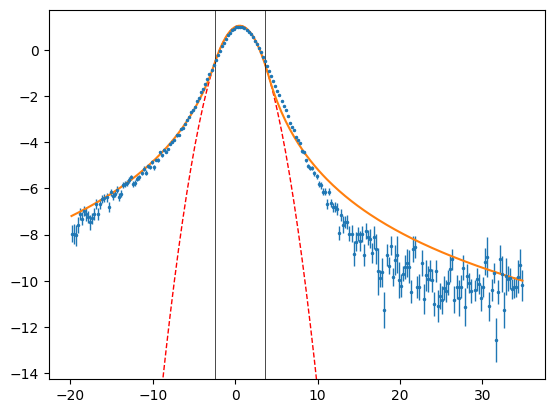

In [16]:
dscb_plot(*cs2)

In [17]:
cs3 = gradient_descent([3,4],cs2)


***** Iteration 0 *****
αL = 1.8029909506425232 → 1.795613408088684, ∂f/∂αL = 7377.48974609375
nL = 3.6670567989349365 → 3.6671130657196045, ∂f/∂nL = -0.0562591552734375
f = 11431.9
df = 7377.49

***** Iteration 1 *****
αL = 1.795613408088684 → 1.7894970178604126, ∂f/∂αL = 6116.369140625
nL = 3.6671130657196045 → 3.767112970352173, ∂f/∂nL = -144.527099609375
f = 11385.8
df = 6118.08

***** Iteration 2 *****
αL = 1.7894970178604126 → 1.782497525215149, ∂f/∂αL = 6999.486328125
nL = 3.767112970352173 → 3.743682622909546, ∂f/∂nL = 23.430381774902344
f = 11344.4
df = 6999.53

***** Iteration 3 *****
αL = 1.782497525215149 → 1.7771599292755127, ∂f/∂αL = 5337.6025390625
nL = 3.743682622909546 → 3.8436825275421143, ∂f/∂nL = -176.47291564941406
f = 11304.5
df = 5340.52

***** Iteration 4 *****
αL = 1.7771599292755127 → 1.77085280418396, ∂f/∂αL = 6307.0712890625
nL = 3.8436825275421143 → 3.8471426963806152, ∂f/∂nL = -3.4601593017578125
f = 11267.8
df = 6307.07

***** Iteration 5 *****
αL = 1.77

C = 1.0380192582582533
μ = 0.540585738750726
σ = 1.6864127519664267
αL = 1.642443299293518
nL = 4.992313385009766
αH = 2.099476293010147
nH = 3.594661235809326


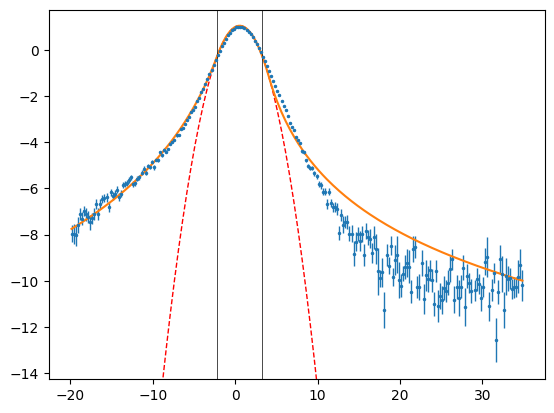

In [18]:
dscb_plot(*cs3)

In [19]:
cs4 = gradient_descent([5,6],cs3)


***** Iteration 0 *****
αH = 2.099476293010147 → 2.0796282291412354, ∂f/∂αH = 19848.046875
nH = 3.594661235809326 → 3.594623565673828, ∂f/∂nH = 0.03765869140625
f = 10479.4
df = 19848

***** Iteration 1 *****
αH = 2.0796282291412354 → 2.061105251312256, ∂f/∂αH = 18523.08203125
nH = 3.594623565673828 → 3.6946234703063965, ∂f/∂nH = -174.5853271484375
f = 10122.5
df = 18523.9

***** Iteration 2 *****
αH = 2.061105251312256 → 2.0429999828338623, ∂f/∂αH = 18105.16796875
nH = 3.6946234703063965 → 3.794623374938965, ∂f/∂nH = -177.63092041015625
f = 9780.81
df = 18106

***** Iteration 3 *****
αH = 2.0429999828338623 → 2.0253472328186035, ∂f/∂αH = 17652.830078125
nH = 3.794623374938965 → 3.894623279571533, ∂f/∂nH = -181.41180419921875
f = 9455.02
df = 17653.8

***** Iteration 4 *****
αH = 2.0253472328186035 → 2.0081734657287598, ∂f/∂αH = 17173.65234375
nH = 3.894623279571533 → 3.9946231842041016, ∂f/∂nH = -185.4664306640625
f = 9145.58
df = 17174.7

***** Iteration 5 *****
αH = 2.0081734657287

C = 1.0380192582582533
μ = 0.540585738750726
σ = 1.6864127519664267
αL = 1.642443299293518
nL = 4.992313385009766
αH = 1.580890417098999
nH = 8.6242036819458


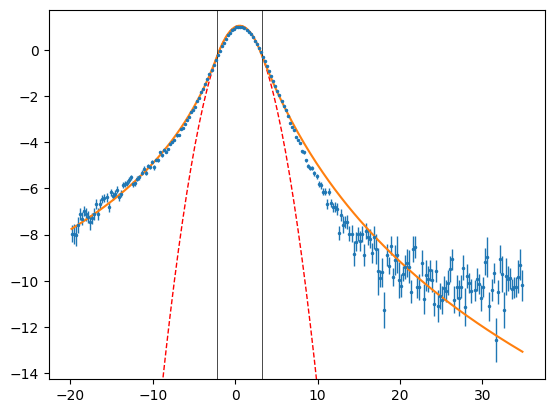

In [20]:
dscb_plot(*cs4)

In [21]:
cs5 = gradient_descent([0,1,2, 3,4, 5,6],cs4)


***** Iteration 0 *****
C = 1.0380192582582533 → 1.0309844017028809, ∂f/∂C = 70348.4375
μ = 0.540585738750726 → 0.5459006428718567, ∂f/∂μ = -10629.7939453125
σ = 1.6864127519664267 → 1.6851587295532227, ∂f/∂σ = 12541.103515625
αL = 1.642443299293518 → 1.6424431800842285, ∂f/∂αL = 0.093994140625
nL = 4.992313385009766 → 4.992314338684082, ∂f/∂nL = -0.00103759765625
αH = 1.580890417098999 → 1.5808902978897095, ∂f/∂αH = 0.082763671875
nH = 8.6242036819458 → 8.624205589294434, ∂f/∂nH = -0.002349853515625
f = 4129.6
df = 72243.9

***** Iteration 1 *****
C = 1.0309844017028809 → 1.0254192352294922, ∂f/∂C = 55651.078125
μ = 0.5459006428718567 → 0.5498871207237244, ∂f/∂μ = -7972.904296875
σ = 1.6851587295532227 → 1.6848735809326172, ∂f/∂σ = 2851.125
αL = 1.6424431800842285 → 1.6406699419021606, ∂f/∂αL = 1773.217529296875
nL = 4.992314338684082 → 4.905126571655273, ∂f/∂nL = 87.18753051757812
αH = 1.5808902978897095 → 1.5802521705627441, ∂f/∂αH = 638.078369140625
nH = 8.624205589294434 → 8.6104

df = 363.64

***** Iteration 234 *****
C = 0.9738783240318298 → 0.9738667011260986, ∂f/∂C = 116.05859375
μ = 0.5708642601966858 → 0.5708667039871216, ∂f/∂μ = -4.91650390625
σ = 1.743422031402588 → 1.7434536218643188, ∂f/∂σ = -316.408203125
αL = 1.6632229089736938 → 1.6632996797561646, ∂f/∂αL = -76.7744140625
nL = 4.996372699737549 → 4.995850563049316, ∂f/∂nL = 0.5220947265625
αH = 1.6811047792434692 → 1.6812021732330322, ∂f/∂αH = -97.35403442382812
nH = 7.8265838623046875 → 7.825662612915039, ∂f/∂nH = 0.92138671875
f = 2527.76
df = 359.139

***** Iteration 235 *****
C = 0.9738667011260986 → 0.9738552570343018, ∂f/∂C = 114.552734375
μ = 0.5708667039871216 → 0.5708691477775574, ∂f/∂μ = -4.89892578125
σ = 1.7434536218643188 → 1.7434848546981812, ∂f/∂σ = -312.625
αL = 1.6632996797561646 → 1.6633754968643188, ∂f/∂αL = -75.833984375
nL = 4.995850563049316 → 4.995335102081299, ∂f/∂nL = 0.51531982421875
αH = 1.6812021732330322 → 1.6812983751296997, ∂f/∂αH = -96.1480712890625
nH = 7.82566261291

C = 0.9729864001274109 → 0.9729857444763184, ∂f/∂C = 6.5009765625
μ = 0.5710618495941162 → 0.5710620284080505, ∂f/∂μ = -0.30517578125
σ = 1.7458523511886597 → 1.745854139328003, ∂f/∂σ = -17.513671875
αL = 1.6691184043884277 → 1.6691226959228516, ∂f/∂αL = -4.250244140625
nL = 4.956524848937988 → 4.956496238708496, ∂f/∂nL = 0.0285491943359375
αH = 1.6886605024337769 → 1.6886659860610962, ∂f/∂αH = -5.534881591796875
nH = 7.755401134490967 → 7.755349636077881, ∂f/∂nH = 0.05169677734375
f = 2526.65
df = 19.9446

***** Iteration 469 *****
C = 0.9729857444763184 → 0.9729850888252258, ∂f/∂C = 6.4501953125
μ = 0.5710620284080505 → 0.5710621476173401, ∂f/∂μ = -0.2373046875
σ = 1.745854139328003 → 1.7458558082580566, ∂f/∂σ = -17.267578125
αL = 1.6691226959228516 → 1.6691268682479858, ∂f/∂αL = -4.181884765625
nL = 4.956496238708496 → 4.956467151641846, ∂f/∂nL = 0.0289459228515625
αH = 1.6886659860610962 → 1.6886714696884155, ∂f/∂αH = -5.4825439453125
nH = 7.755349636077881 → 7.755299091339111, ∂f/

df = 1.11574

***** Iteration 708 *****
C = 0.9729366302490234 → 0.9729365706443787, ∂f/∂C = 0.3408203125
μ = 0.5710736513137817 → 0.5710736513137817, ∂f/∂μ = -0.01904296875
σ = 1.745987892150879 → 1.7459880113601685, ∂f/∂σ = -0.9501953125
αL = 1.6694456338882446 → 1.6694458723068237, ∂f/∂αL = -0.2451171875
nL = 4.954331874847412 → 4.954329490661621, ∂f/∂nL = 0.00238037109375
αH = 1.6890873908996582 → 1.6890877485275269, ∂f/∂αH = -0.300079345703125
nH = 7.751391887664795 → 7.751389503479004, ∂f/∂nH = 0.0023193359375
f = 2526.65
df = 1.08145

***** Iteration 709 *****
C = 0.9729365706443787 → 0.9729365110397339, ∂f/∂C = 0.341796875
μ = 0.5710736513137817 → 0.5710736513137817, ∂f/∂μ = -0.01025390625
σ = 1.7459880113601685 → 1.745988130569458, ∂f/∂σ = -0.8759765625
αL = 1.6694458723068237 → 1.6694461107254028, ∂f/∂αL = -0.26513671875
nL = 4.954329490661621 → 4.954329013824463, ∂f/∂nL = 0.0005645751953125
αH = 1.6890877485275269 → 1.6890881061553955, ∂f/∂αH = -0.306884765625
nH = 7.7513895


***** Iteration 939 *****
C = 0.972934901714325 → 0.972934901714325, ∂f/∂C = 0.1376953125
μ = 0.5710740685462952 → 0.5710740685462952, ∂f/∂μ = -0.041015625
σ = 1.74599289894104 → 1.74599289894104, ∂f/∂σ = -0.556640625
αL = 1.6694591045379639 → 1.6694591045379639, ∂f/∂αL = -0.04638671875
nL = 4.954236030578613 → 4.954236030578613, ∂f/∂nL = 4.57763671875e-05
αH = 1.6891045570373535 → 1.6891045570373535, ∂f/∂αH = -0.050048828125
nH = 7.751224994659424 → 7.751224994659424, ∂f/∂nH = 0.00018310546875
f = 2526.65
df = 0.578919

***** Iteration 940 *****
C = 0.972934901714325 → 0.972934901714325, ∂f/∂C = 0.1376953125
μ = 0.5710740685462952 → 0.5710740685462952, ∂f/∂μ = -0.041015625
σ = 1.74599289894104 → 1.74599289894104, ∂f/∂σ = -0.556640625
αL = 1.6694591045379639 → 1.6694591045379639, ∂f/∂αL = -0.04638671875
nL = 4.954236030578613 → 4.954236030578613, ∂f/∂nL = 4.57763671875e-05
αH = 1.6891045570373535 → 1.6891045570373535, ∂f/∂αH = -0.050048828125
nH = 7.751224994659424 → 7.751224994659424

C = 0.972934901714325
μ = 0.5710740685462952
σ = 1.74599289894104
αL = 1.6694591045379639
nL = 4.954236030578613
αH = 1.6891045570373535
nH = 7.751224994659424


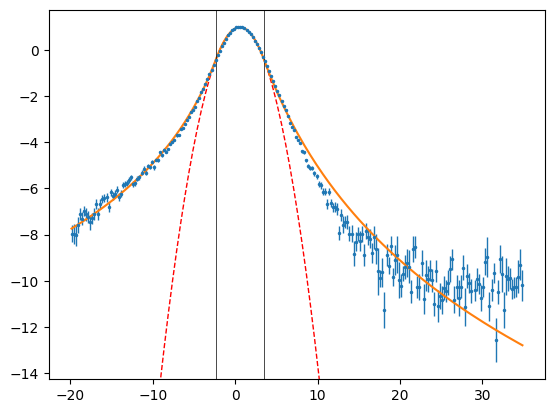

In [22]:
dscb_plot(*cs5)